In [1]:
from os import listdir, mkdir
import shutil
import numpy as np
import scipy
import scipy.optimize as opt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
%matplotlib inline 
#%matplotlib tk
import openSif4 as sif
from skimage import measure
from datetime import date
from sklearn.cluster import KMeans
from matplotlib.widgets import Slider
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import imutils
import cv2

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
channelDict = ["Vermillion","Bluish Green","Sky Blue","Reddish Purple", "Full"]
colorDict = [(213/255, 94/255, 0, 1),(0, 158/255, 115/255, 1),(86/255, 180/255, 223/255, 1),  (204/255, 121/255, 167/255, 1),(0.5,0.5,0.5, 1)]
cmapDict = ["Reds", "Greens", "Blues", "gray", "hsv"]
cbCmaps = [matplotlib.colors.LinearSegmentedColormap.from_list("", [(1,1,1,0), colorDict[0]]),
         matplotlib.colors.LinearSegmentedColormap.from_list("", [ (1,1,1,0),colorDict[1]]),
         matplotlib.colors.LinearSegmentedColormap.from_list("", [(1,1,1,0),colorDict[2]]),
        matplotlib.colors.LinearSegmentedColormap.from_list("", [(1,1,1,0),colorDict[3]])]

cmaps = [matplotlib.colors.LinearSegmentedColormap.from_list("", [(1,1,1,0), "red"]),
         matplotlib.colors.LinearSegmentedColormap.from_list("", [ (1,1,1,0),"green"]),
         matplotlib.colors.LinearSegmentedColormap.from_list("", [(1,1,1,0),"blue"]),
        matplotlib.colors.LinearSegmentedColormap.from_list("", [(1,1,1,0),"violet"])]

def gaussian(height, center_x, center_y, width_x, width_y, bk):
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2) + bk

def gaussian1D(x, scale, mean, sigma):
    return scale*np.exp(-((x-mean)**2)/(2*(sigma**2)))


def moments(data):
    # Initial Guess Calculator
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    bk = total/(len(X)*len(Y))
    return height, x, y, width_x, width_y, bk

def fitgaussian(data):
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, hess_inv, infodict, errmsg, success = opt.leastsq(errorfunction, params, full_output=1)
    return p, hess_inv


def integrateToGaussian(H, sigmaBounds = 0.2,axel = None, cmap_ = "gray"):
    shapes = np.shape(H)
    x = np.arange(0, shapes[0]**2) % shapes[0]
    y = np.arange(0, shapes[1]**2) % shapes[1]
    z = np.ravel(H)
    x, y = np.meshgrid(np.arange(0, shapes[0]), np.arange(0, shapes[1]))
    
    try: 
        popt, hess_inv = fitgaussian(H)
        pcov = hess_inv #######
        fit = gaussian(*popt)
    except RuntimeError: 
        r_squared = 0
        integratedValue=0
        popt = 0
        pcov = 0
        intErr = None
        #print("Failed Fit by Error")
    else: 
        data_fitted = fit(*np.indices(H.shape))
        if not(popt[4]/popt[3] > 1 + sigmaBounds or popt[4]/popt[3] < 1-sigmaBounds):
            integratedValue = np.pi*popt[0]*popt[3]*popt[4]*2
            if (not (axel is None)):
                axel.imshow(data_fitted ,cmap = "gray", origin = "lower")

            residuals = z - np.ravel(data_fitted)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((z-np.mean(z))**2)
            r_squared = 1 - (ss_res / ss_tot)
            var = np.sum(residuals**2/(len(residuals) - 1))
            intErr = np.sqrt(var/(len(residuals) - 1))
        else:
            #print(popt[4]/popt[3])
            if (not (axel is None)):
                axel.imshow(data_fitted ,cmap = cmap_, origin = "lower")
                axel.set_title("Fit Failed by Assymetry: r = %.2f" %(popt[4]/popt[3]))
            r_squared = 0
            integratedValue=0
            popt = 0
            pcov = 0
            intErr = None
            #print("Failed Fit by Assymetry")
    #print(r_squared)###########
    #print(popt)###########
    return (integratedValue, intErr, popt, pcov, r_squared)
        
def sh(a):
    print(np.shape(a)) 
    
    
def convertToPowerDensity100x(current, sigma = 0.509): # Current in mA As of MAY 2023
    powerOut = (0.37103648*current -26.23050549)/1000
    sigmaPostObj = 2*sigma/150
    radius = 2*sigmaPostObj/10 #cm
    area = np.pi*radius*radius
    return powerOut/(area) #W/cm^2

def convertToPowerDensity60x(current, sigma = 0.388): # Current in mA As of JUNE 27th 2023
    powerOut = (0.29187857*current -17.90535715)/1000
    sigmaPostObj = 3.3*sigma/150 #3.3 mm is the 
    radius = 2*sigmaPostObj/10 #cm
    area = np.pi*radius*radius
    return powerOut/(area) #W/cm^2



def stdErr(pcov, N):
    return np.sqrt(np.diag(pcov)/N)

def nameToProperty(nameList):
    propertyList = []
    for name in nameList:
        p = (name.split("_"))
        if len(p) < 6:
            p += ["No Notes"]
        p[1] = zip(stringToDiameter(p[1]))
        propertyList += [p]
    return propertyList

def stringToDiameter(string):
    string = string.replace("p", ".")
    splits = string.split("S")
    core = splits[0]
    core = float(core[1:])
    shells = []
    for i in range(len(splits)-1):
        shells += [float(splits[i+1])]
    shellSizes = (np.array(shells)-core)/2
    return shellSizes

def unzip(zipz):
    unzi = []
    for z in zipz:
        unzi += [list(z)]
    return unzi

def autoFinder(H, bit = 3, thresh = 0.9, sig = 3, centroidLimit = 150):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    kernel1 = np.array([[1, 1, 1],
                      [1,  16, 1],
                      [1, 1, 1]])
    kernel2 = np.array([[-1, -1, -1, -1, -1],
                        [-1,  1,  2,  1, -1],
                        [-1,  2,  4,  2, -1],
                        [-1,  1,  2,  1, -1],
                        [-1, -1, -1, -1, -1]])
    kernel = kernel1
    
    image = (scipy.ndimage.convolve(H, kernel))

    m = np.mean(image)
    std = np.std(image)
    image[image > m + sig*std] = m + sig*std
    image /= np.amax(image)
    image[image < thresh] = 0
    
    image = (scipy.ndimage.convolve(image, kernel))
    image = (scipy.ndimage.convolve(image, kernel))
    image = (scipy.ndimage.convolve(image, kernel))
    image = (scipy.ndimage.convolve(image, kernel))
    image = (scipy.ndimage.convolve(image, kernel))
    image = (scipy.ndimage.convolve(image, kernel))
    image = (scipy.ndimage.convolve(image, kernel))
    
    m = np.mean(image)
    std = np.std(image)
    image[image > m + sig*std] = m + sig*std
    image /= np.amax(image)
    image[image < thresh] = 0
    
    aa = image[:]
    neighborhood = generate_binary_structure(2,2)
    local_max = maximum_filter(image, size = (bit,bit))==image
    background = (image==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    detected_peaks = local_max ^ eroded_background

    labels = measure.label(detected_peaks, background=0)
    bg_label = labels[0,0] 
    labels[labels==bg_label] = 0
    props = measure.regionprops(labels)
    centroids = []
    for prop in props:
        my_centroid = prop.centroid
        centroids+= [my_centroid]
        
    centroids = centroids[:min(len(centroids), centroidLimit)]     
    x,y = np.transpose(centroids)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    pos = ax2.imshow(H, cmap = "jet", origin = "lower")
    pos = ax1.imshow(aa, cmap = "gray", origin = "lower")
    ax2.plot(y,x, marker = "+", linewidth = 0, c = (1,0,0), markersize = 10)
    return np.transpose([x,y])

def brightnessAnalysis(Im,FOV = 6, bit = 3, thresh = 0.91, sig = 3, maxAsymetry = 0.2, maxSig = 4,
                       stringency = 0.7, centroidLimit = 150 ,
                       plotHistograms = False , plotFit = False, c = 3, plotLimit = 100, 
                       blinkstd = 5):
    plotCounter = 0
    averageBrightness = []
    brightnessError = []
    adderAverageBrightness = None
    adderBrightnessError = None
    
    summedImage = np.sum(Im, axis = 0)
    centers = autoFinder(summedImage, bit, thresh, sig, centroidLimit)
    if thresh > 0.993:
        %matplotlib tk
        figg, axx = plt.subplots(figsize=(7, 7)) 
        axx.imshow(summedImage)
        plt.show()
        x,y = np.transpose(plt.ginput(100, timeout = 10000))
        (centers) = np.transpose([y,x])
    
    
    for peak in centers:
        dcenterx = int(peak[1])
        dcentery = int(peak[0])
        if (dcenterx - FOV > 0) and (dcenterx + FOV < np.shape(summedImage)[0]) and  (dcentery - FOV > 0) and (dcentery + FOV < np.shape(summedImage)[1]):
            
            if len(Im) > 1:
                trim = Im[:,dcentery-FOV:dcentery+FOV, dcenterx-FOV:dcenterx+FOV]

                trace = np.einsum('ijk->i', trim)#/np.prod(np.shape(trim))
                edges1 = Im[:,dcentery-FOV-1:dcentery-FOV, dcenterx-FOV:dcenterx+FOV]
                edges2 = Im[:,dcentery+FOV:dcentery+FOV + 1, dcenterx-FOV:dcenterx+FOV]
                edges3 = Im[:,dcentery-FOV:dcentery+FOV, dcenterx-FOV-1:dcenterx-FOV ]
                edges4 = Im[:,dcentery-FOV:dcentery+FOV, dcenterx+FOV:dcenterx+FOV+1]
                kov = FOV-1
                edges5 = Im[:,dcentery-FOV-2:dcentery-FOV-1, dcenterx-kov:dcenterx+kov-1]
                edges6 = Im[:,dcentery+FOV+1:dcentery+FOV + 2, dcenterx-kov:dcenterx+kov-1]
                edges7 = Im[:,dcentery-kov:dcentery+kov-1, dcenterx-FOV-2:dcenterx-FOV-1 ]
                edges8 = Im[:,dcentery-kov:dcentery+kov-1, dcenterx+FOV+1:dcenterx+FOV+2]
                edgeTrace = np.einsum('ijk->i', edges1) + np.einsum('ijk->i', edges2) +np.einsum('ijk->i', edges3) +np.einsum('ijk->i', edges4) +  np.einsum('ijk->i', edges5) + np.einsum('ijk->i', edges6) +np.einsum('ijk->i', edges7) +np.einsum('ijk->i', edges8)
                OnThresh = np.mean(edgeTrace)
                stdThresh = np.std(edgeTrace)
                interval = 10
                stds = 2
                convolveFunction = scipy.stats.norm.pdf(np.arange(interval), interval/2, stds)
                convolveFunction += (1 - np.sum(convolveFunction))/interval
                averages = trace#np.convolve(trace, convolveFunction, mode='same')   
                averages[averages < 0.9*np.amin(OnThresh)] =  0.9*np.amin(OnThresh)
                ON =np.array(averages > OnThresh + blinkstd*stdThresh)

                #fisg, (tax) = plt.subplots(figsize=(7, 7))
                #tax.plot(trace, color = (1,0,0.5,0.5))
                #tax.plot(edgeTrace, color = (0,1,0.5,0.5))
                #tax.plot(averages)
                #tax.plot((np.amax(averages)- np.amin(averages))*ON + np.amin(averages), linewidth = 2, color = (0,0,0,1))
                #sh(trim[ON])
                try:
                    Am = np.sum(trim[ON], axis = 0)/len(trim[ON])#np.sum(ON)
                    #print(Am)
                except IndexError:
                    Am = np.sum(trim, axis = 0)/len(trim)#np.sum(ON)
            else:
                Am = Im[0,dcentery-FOV:dcentery+FOV, dcenterx-FOV:dcenterx+FOV]
                #Am = np.sum(trim, axis = 0)/len(trim)
                
            if plotFit and (plotCounter < plotLimit):
                fig, (axx,axy) = plt.subplots(1,2,figsize=(7, 7))
                integratedValue, intErr, popt, pcov, R2 = integrateToGaussian(Am, maxAsymetry, axy, cmap_ = cmapDict[c])
                pos = axx.imshow(Am, cmap = cmapDict[c], origin = "lower")
                axx.set_xlabel("(px)")
                axx.set_ylabel("(px)")
                axx.set_title(fileName)
                cbar = fig.colorbar(pos, ax=axy, pad=0.05, fraction =0.04) 
                cbar = fig.colorbar(pos, ax=axx, pad=0.05, fraction =0.04) 
                cbar.set_label('Photons/s', rotation = 270)
                plotCounter += 1
                
                print(popt)
            else:   
                try:
                    integratedValue, intErr, popt, pcov, R2 = integrateToGaussian(Am, maxAsymetry) 
                except ValueError:
                    integratedValue, intErr, popt, pcov, R2 = 0, None, 0, 0, 0
                
            if R2 > stringency and popt[4] < maxSig and popt[3] < maxSig:
                adderAverageBrightness = np.abs(integratedValue)
                adderBrightnessError = intErr
                initialGuess = np.transpose(popt)
                

        averageBrightness += [adderAverageBrightness]
        brightnessError += [adderBrightnessError]
            
    if plotHistograms:
        fig, axes = plt.subplots(figsize=(7, 7))
        local = [x for x in averageBrightness if x is not None]
        sh(local)
        B, edges = np.histogram(local, bins= max(int(len(local)/5), 10))
        axes.bar(edges[:-1],B, width = edges[1]-edges[0], align = "edge")
        axes.set_xlabel("Brightness (Ph/s)")
        axes.set_ylabel("#/(%.1f Ph/s)"% (edges[1]-edges[0]))
        axes.set_title("Histogram mean: %.2f"%np.mean(local))
    
    return (averageBrightness, brightnessError)

C:\Users\SP001\AppData\Local\Temp\ipykernel_27100\1991130443.py:6: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
C:\Users\SP001\AppData\Local\Temp\ipykernel_27100\1991130443.py:7: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
C:\Users\SP001\AppData\Local\Temp\ipykernel_27100\1991130443.py:7: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion


Select Folder: ['.ipynb_checkpoints', 'BrightnessAnalysis_ver3.ipynb', 'openSif4.py', 'SaturationSeriesAnalyst1FOV.ipynb', 'savedNPY', 'savedSaturationData', 'standardITA', 'tmed5', '__pycache__']


0, 1, 2, ...: 6


Selected Folder: standardITA


Select Color (R, G, B, NIR, Full = 0, 1, 2, 3, 4):  3


Limiter is 64 pixels
Folder: standardITA/saturation_Series/saturation_Series/
.......Folder: standardITA/saturation_Series/saturation_Series/FOV/
..............File: 900.sif
.....................Particles Fit: 24
..............File: 800.sif
.....................Particles Fit: 25
..............File: 700.sif
.....................Particles Fit: 25
..............File: 600.sif
.....................Particles Fit: 25
..............File: 500.sif
.....................Particles Fit: 25
..............File: 400.sif
.....................Particles Fit: 25
..............File: 300.sif
.....................Particles Fit: 25
..............File: 200.sif
.....................Particles Fit: 24
..............File: 150.sif
.....................Particles Fit: 24
..............File: 120.sif
.....................Particles Fit: 24
..............File: 1000.sif
.....................Particles Fit: 24
..............File: 100.sif
.....................Particles Fit: 23
Done!


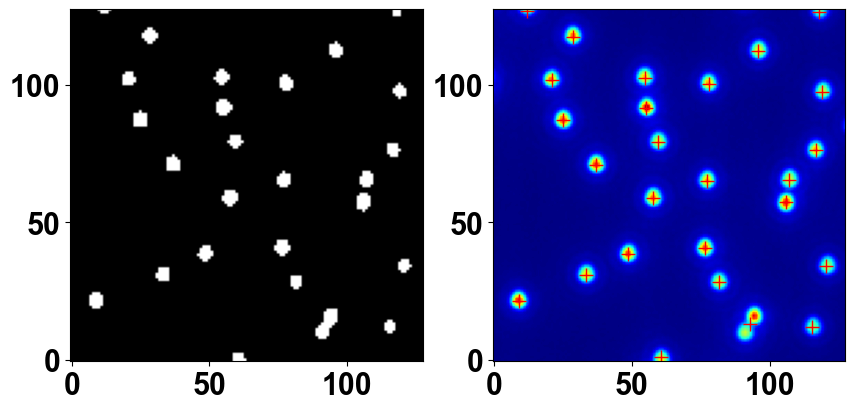

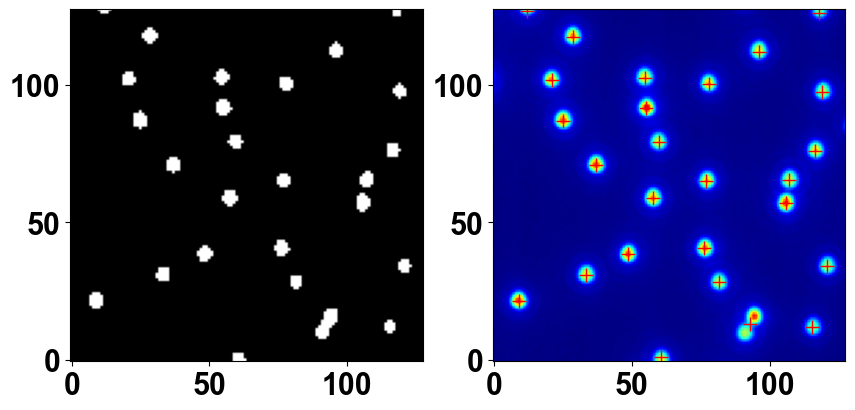

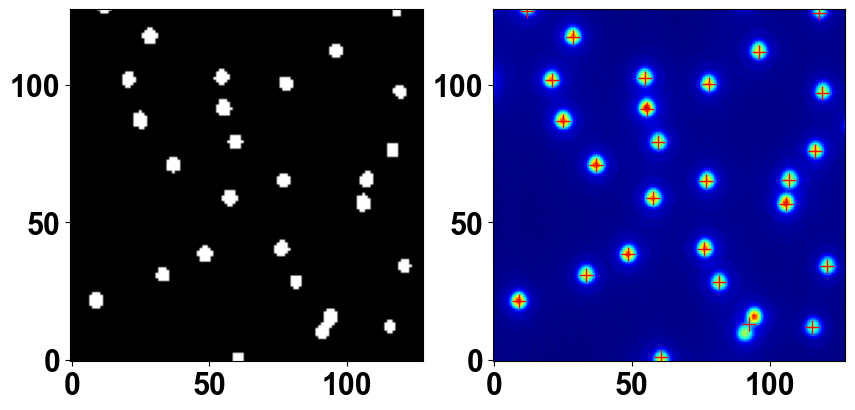

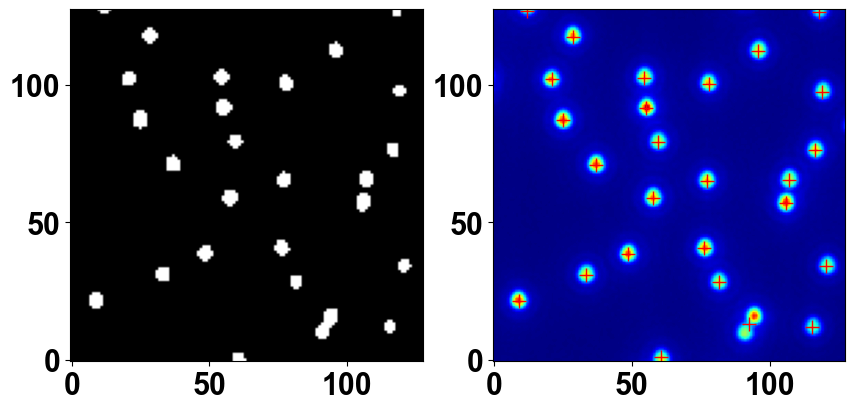

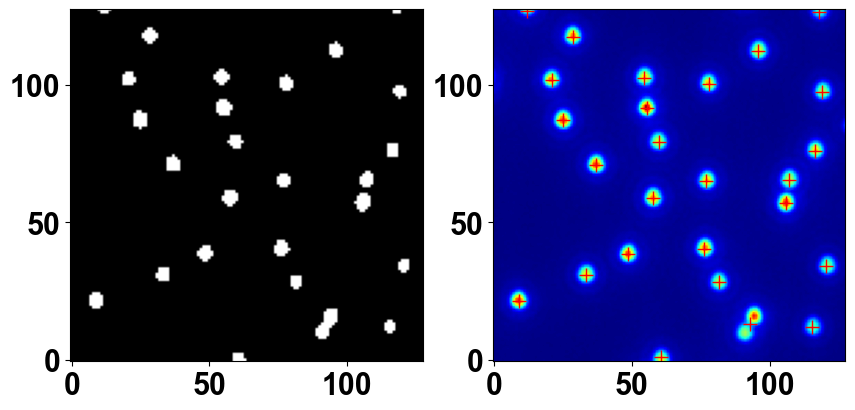

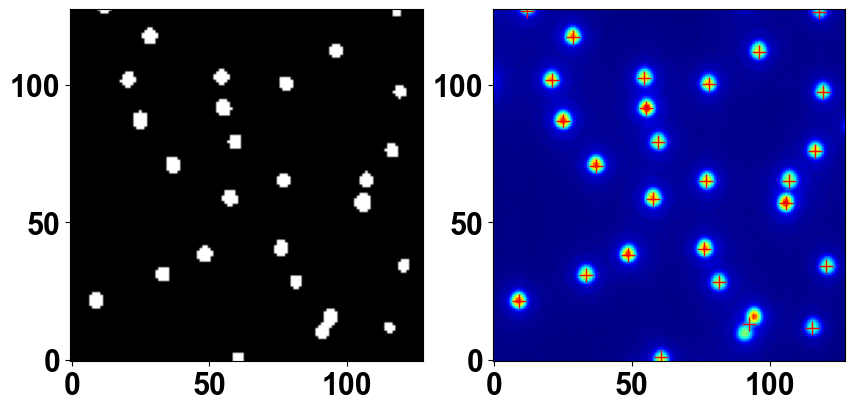

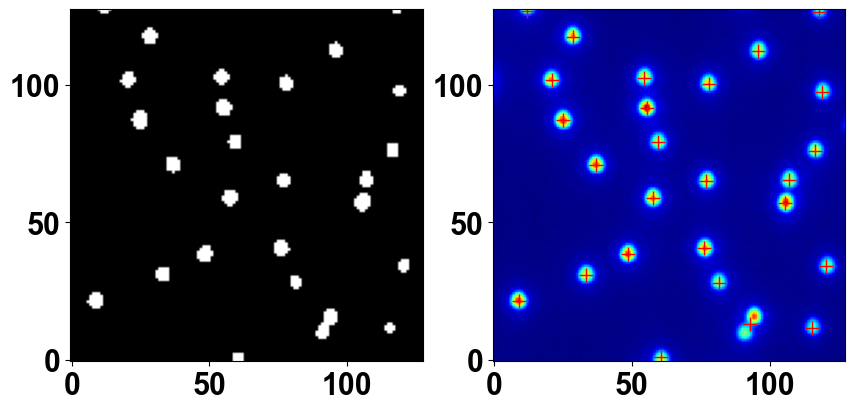

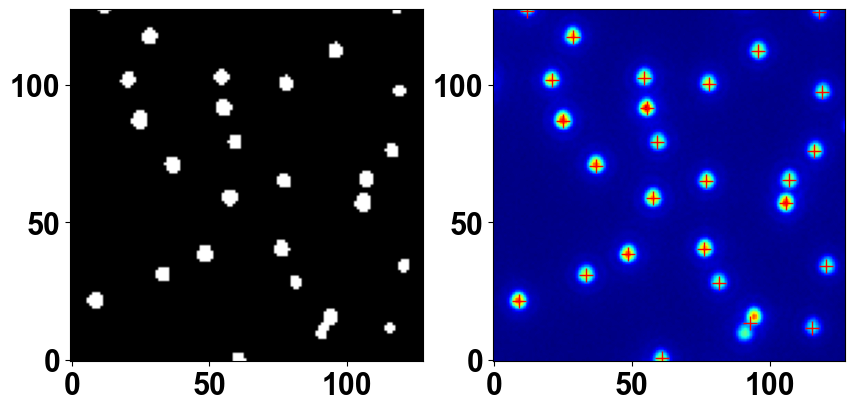

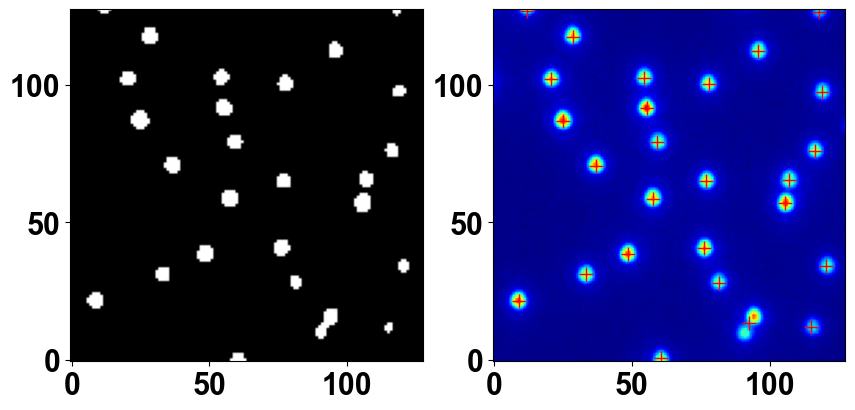

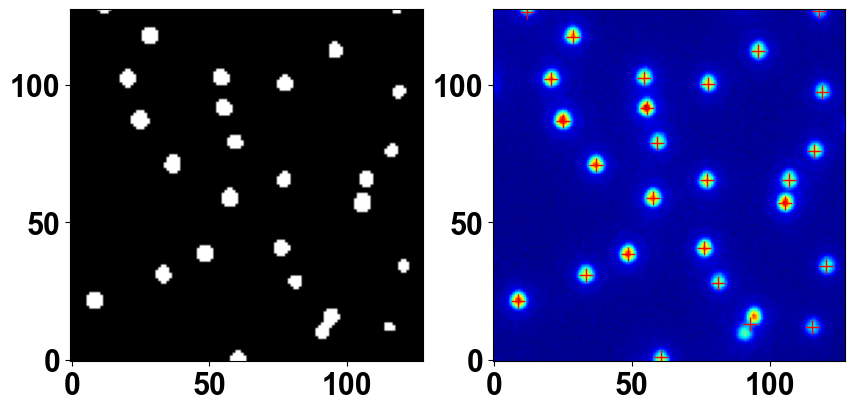

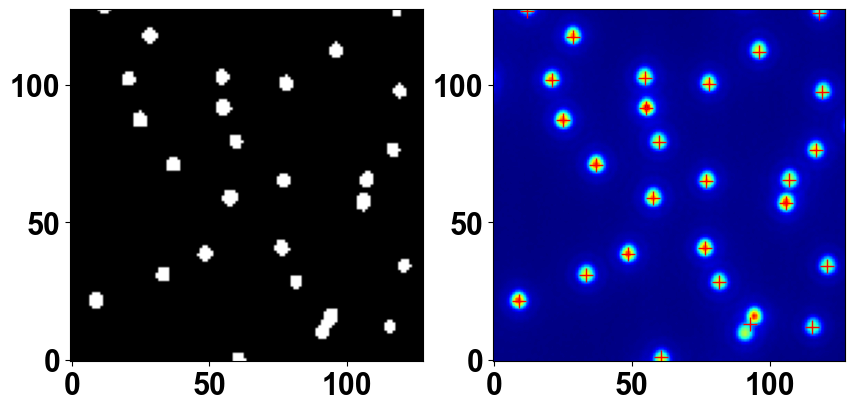

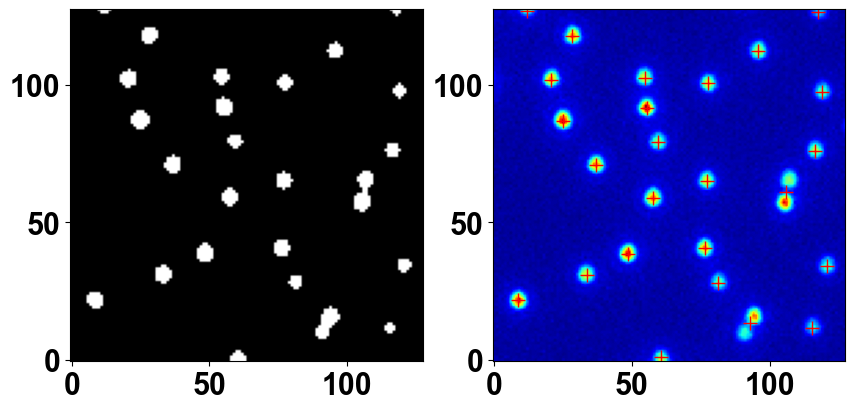

In [6]:
experimentFolders =  listdir() 
print("Select Folder: " , end = "")
print(experimentFolders)
SupreFolder = experimentFolders[int(input("0, 1, 2, ...:"))]
print("Selected Folder: " + SupreFolder)
color = int(input("Select Color (R, G, B, NIR, Full = 0, 1, 2, 3, 4): "))# R, G, B, NIR = 0, 1, 2, 3
limiter = 64#px
print("Limiter is %.0f pixels"%limiter)

canonicalCurrents = [100, 120, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

folders =  listdir(SupreFolder) 
preamble = SupreFolder+"/"

try: 
    mkdir("savedNPY")
except FileExistsError:
    pass

try: 
    mkdir("savedSaturationData")
except FileExistsError:
    pass

try: 
    mkdir("savedNPY/"+SupreFolder)
except FileExistsError:
    #shutil.rmtree("savedNPY/"+SupreFolder)
    #mkdir("savedNPY/"+SupreFolder)
    pass
for j in range(len(folders)):
    folderPath = preamble + folders[j] + "/saturation_Series/"
    try: 
        mkdir("savedNPY/"+preamble + folders[j])
    except FileExistsError:
        pass
    try: 
        mkdir("savedNPY/"+preamble + folders[j]+ "/saturation_Series")
    except FileExistsError:
        pass
    
    print("Folder: "+ folderPath)
    FOVfileList =  listdir(folderPath) 
    
    for FOVfile in FOVfileList:
        FOVPath = folderPath + FOVfile + "/"
        try: 
            mkdir("savedNPY/"+folderPath + FOVfile)
        except FileExistsError:
            pass      
        try: 
            mkdir("savedNPY/"+folderPath + FOVfile+"/Ch" + str(color))
        except FileExistsError:
            pass
        
        print(".......Folder: "+ FOVPath)
        fileList =  listdir(FOVPath) 
        fileList.reverse()
        i = 0
        
        for file in fileList:
            print("..............File: " + file)
            fileName = FOVPath + file
            
            try:
                value = float(file[:-4])
            except ValueError:
                override = 1000
                value = override
                print("Overriden File name to %.0f.sif"%value)
            
            powerDensity = convertToPowerDensity60x(value)
            
            
            

            theSif = sif.elSif(fileName)
            theSif.convertToPhotons()
            photons = theSif.photons
            R, G, B, NIR = theSif.RStackPhoton, theSif.GStackPhoton,theSif.BStackPhoton, theSif.NIRStackPhoton
    
            fullImage = photons[0]
            R0, G0, B0, NIR0 = R[0], G[0], B[0], NIR[0]
            colorArr = [R0[limiter:-limiter, limiter:-limiter], 
                        G0[limiter:-limiter, limiter:-limiter], 
                        B0[limiter:-limiter, limiter:-limiter], 
                        NIR0[limiter:-limiter, limiter:-limiter], 
                        fullImage]
            Im = (colorArr[color])[:]
            
            fullImage = photons[:]
            R0, G0, B0, NIR0 = R[:], G[:], B[:], NIR[:]
            colorArr = [R0[:,limiter:-limiter, limiter:-limiter], 
                            G0[:,limiter:-limiter, limiter:-limiter], 
                            B0[:,limiter:-limiter, limiter:-limiter], 
                            NIR0[:,limiter:-limiter, limiter:-limiter], 
                            fullImage]
            Im = (colorArr[color])[:]
            threshold = 0.999*(value < 0) + 0.95*(not (value < 0))
            averageBrightness, brightnessError = brightnessAnalysis(Im, 
                                                                    FOV = 3, bit = 3, 
                                                                    thresh = threshold, sig =3, maxAsymetry = 0.3
                                                                    , maxSig = 3, 
                                                                    stringency = 0.5 , centroidLimit = 300,
                                                                    plotHistograms =0 , plotFit =0
                                                                    , c = color, plotLimit = 3)
            print(".....................Particles Fit: "+ str( len([x for x in averageBrightness if x is not None])))
            #print(averageBrightness)
            np.save("savedNPY/"+folderPath + FOVfile+"/Ch" + str(color) +"/"+file[:-4], np.array([powerDensity*np.ones(np.shape(averageBrightness)),averageBrightness, brightnessError]))
            i += -1
print("Done!")